# Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import random

from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import plotly
import seaborn as sns
import shap
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

In [3]:
# Paths
WORKING_DIR = "/kaggle/working/"
DATA_PATH = "/kaggle/input/ct-slice-localization/slice_localization_data.csv"

In [4]:
# Reproducibility
RANDOM_SEED = 99
keras.utils.set_random_seed(RANDOM_SEED)

In [5]:
# Load models and shap values if already present
LOAD_MODELS = False
LOAD_SHAP = False

# Data Ingestion and Sanity Check

In [6]:
raw_data = pd.read_csv(DATA_PATH)

In [7]:
raw_data.head()

,patientId,value0,value1,value2,value3,value4,value5,value6,value7,value8,...,value375,value376,value377,value378,value379,value380,value381,value382,value383,reference
0,0,0.0,0.0,0.0,0.0,0.0,0.0,-0.25,-0.25,-0.25,...,-0.25,0.980381,0.0,0.0,0.0,0.0,0.0,-0.25,-0.25,21.803851
1,0,0.0,0.0,0.0,0.0,0.0,0.0,-0.25,-0.25,-0.25,...,-0.25,0.977008,0.0,0.0,0.0,0.0,0.0,-0.25,-0.25,21.745726
2,0,0.0,0.0,0.0,0.0,0.0,0.0,-0.25,-0.25,-0.25,...,-0.25,0.977008,0.0,0.0,0.0,0.0,0.0,-0.25,-0.25,21.687600
3,0,0.0,0.0,0.0,0.0,0.0,0.0,-0.25,-0.25,-0.25,...,-0.25,0.977008,0.0,0.0,0.0,0.0,0.0,-0.25,-0.25,21.629474
4,0,0.0,0.0,0.0,0.0,0.0,0.0,-0.25,-0.25,-0.25,...,-0.25,0.976833,0.0,0.0,0.0,0.0,0.0,-0.25,-0.25,21.571348


In [8]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53500 entries, 0 to 53499
Columns: 386 entries, patientId to reference
dtypes: float64(385), int64(1)
memory usage: 157.6 MB


The row index indicates 53500 CT slices. The 386 columns are produced from concatenating 2 histograms.

In [9]:
# Number of patient
raw_data["patientId"].unique().shape

(97,)

There seems to be a discrepancy between the dataset and data description. The data description states that there are "... 74 different 
patients (43 male, 31 female)". The dataset contains 97 unique patient IDs. 

Now, let's check if every patient ID has the same amount of CT slices.

In [10]:
# Size of groupby indicates the number of rows
raw_data.groupby("patientId").size().describe()

count      97.000000
mean      551.546392
std       388.755574
min        66.000000
25%       147.000000
50%       499.000000
75%       807.000000
max      1749.000000
dtype: float64

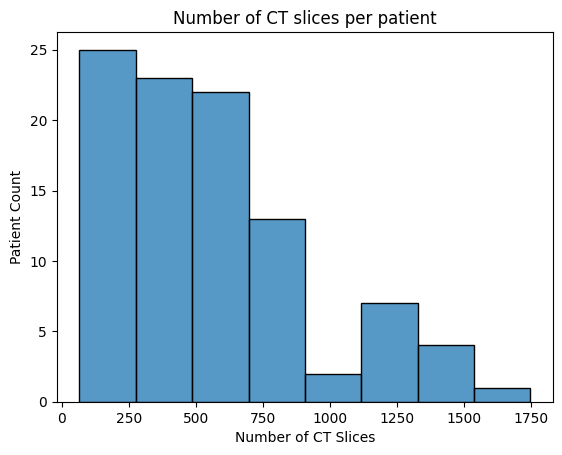

In [11]:
sns.histplot(raw_data.groupby("patientId").size())
plt.title("Number of CT slices per patient")
plt.ylabel("Patient Count")
plt.xlabel("Number of CT Slices");

Most of the patients have <1000 CT slices. The average number of CT slices per patient is 551 slices.

In [12]:
# Columns of histograms for easier slicing
hist_cols = [f"value{i}" for i in range(384)]

In [13]:
# Check for missing values
raw_data[hist_cols].isna().sum().sum()

0

The data description states that "bins that are outside of the image are marked with the value -0.25". Let's check the number of such instances.

In [14]:
num_bins_outside = (raw_data[hist_cols] == -0.25).sum().sum()
print(f"Number of bins that are outside of the image: {num_bins_outside:,}")
print("Percentage of bins that are outside of the image: "
      f"{(num_bins_outside / raw_data[hist_cols].size) * 100:.2f}%")

Number of bins that are outside of the image: 3,311,592
Percentage of bins that are outside of the image: 16.12%


Looks like there is a small number of bins that are outside of the image.

That should be enough data sanity check for now. Let's create the test set before doing further analysis to prevent us from learning about test set too much.

# Test Data Split

The test set is going to be created by randomly selecting patient IDs to imitate situations that we have to predict unseen patient data.

In [15]:
# train:val:test -> 60:20:20
TRAIN_SIZE = 0.6
VAL_SIZE = 0.2

In [16]:
unique_patient_ids = raw_data["patientId"].unique().tolist()
shuffled_patient_ids = unique_patient_ids.copy()
# Use random seed to replicate shuffle result
random.Random(RANDOM_SEED).shuffle(shuffled_patient_ids)

In [17]:
num_train_ids = int(len(shuffled_patient_ids) * TRAIN_SIZE)
num_val_ids = int(len(shuffled_patient_ids) * VAL_SIZE)
train_ids = shuffled_patient_ids[:num_train_ids]
val_ids = shuffled_patient_ids[num_train_ids : num_train_ids + num_val_ids]
test_ids = shuffled_patient_ids[num_train_ids + num_val_ids:]
print(f"Number of patient IDs in training set: {len(train_ids)}")
print(f"Number of patient IDs in validation set: {len(val_ids)}")
print(f"Number of patient IDs in test set: {len(test_ids)}")

Number of patient IDs in training set: 58
Number of patient IDs in validation set: 19
Number of patient IDs in test set: 20


In [18]:
# Include validation data in training data for EDA and split later
train_data = raw_data[raw_data["patientId"].isin(train_ids + val_ids)]
test_data = raw_data[raw_data["patientId"].isin(test_ids)]
print(f"Shape of training set: {train_data.shape}")
print(f"Shape of test set: {test_data.shape}")

Shape of training set: (41976, 386)
Shape of test set: (11524, 386)


# Exploratory Data Analysis

Now data splitting is out of the way, let's try to get a more in-depth understanding of the training data.

## Bone Structure and Air Inclusions


The data description states that

value[1-241]: Histogram describing bone structures <br>
value[242 - 385]: Histogram describing air inclusions

Let's take a look at their differences.

In [19]:
bone_cols = [f"value{i}" for i in range(1, 242)]
air_cols = [f"value{i}" for i in range(242, 384)]

Important note: The data description states that there are 385 histogram values from 1 to 385. There are actually 384 histogram values in the dataset (0 to 383). 

For the purpose of this analysis, the boundary between the two histograms are assumed to be 241.

In [20]:
# Sample some patients for slices visualization
sample_patient_1_data = train_data[train_data["patientId"] == train_ids[0]]
sample_patient_2_data = train_data[train_data["patientId"] == train_ids[1]]

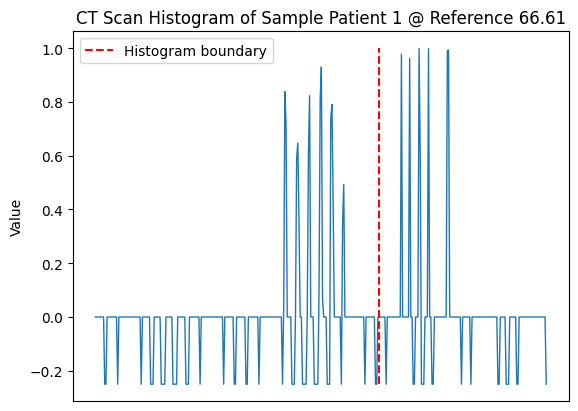

In [21]:
# Before separating bone structures and air inclusions
sns.lineplot(sample_patient_1_data[hist_cols].iloc[0], linewidth=1)
plt.ylabel("Value")
plt.xticks([])
plt.title("CT Scan Histogram of Sample Patient 1 "
          f"@ Reference {sample_patient_1_data.iloc[[0]]['reference'].values[0]:.2f}")
plt.vlines(241, -0.25, 1, colors="red", linestyle="--", label="Histogram boundary")
plt.legend()
plt.show();

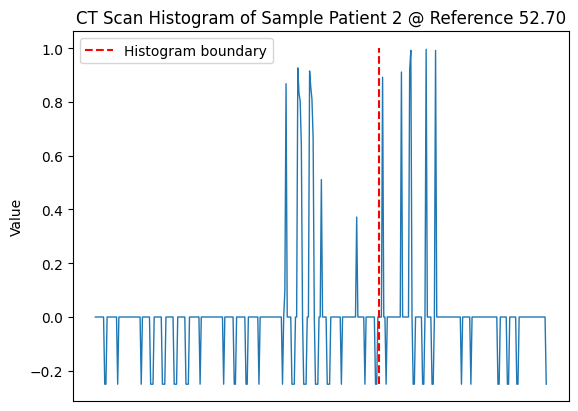

In [22]:
sns.lineplot(sample_patient_2_data[hist_cols].iloc[0], linewidth=1)
plt.ylabel("Value")
plt.xticks([])
plt.title("CT Scan Histogram of Sample Patient 2 "
          f"@ Reference {sample_patient_2_data.iloc[[100]]['reference'].values[0]:.2f}")
plt.vlines(241, -0.25, 1, colors="red", linestyle="--", label="Histogram boundary")
plt.legend()
plt.show();

From the samples that we seen, it seems like the histograms of bone structures and air inclusions differs from each other and change with the reference angle as well.

Let's separate the histograms and plot some more samples to make sure.

In [23]:
def plot_sample_histograms(row: pd.DataFrame):
    patient_id = row["patientId"].values[0]
    reference = row["reference"].values[0]
    bone_hist = row[bone_cols].iloc[0]
    air_hist = row[air_cols].iloc[0]
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    # Bone structures plot
    sns.lineplot(bone_hist, ax=axes[0])
    axes[0].set_ylabel("Value")
    axes[0].set_xticks([])
    axes[0].set_title("Bone Structures")
    # Air inclusions plot
    sns.lineplot(air_hist, ax=axes[1])
    axes[1].set_ylabel("Value")
    axes[1].set_xticks([])
    axes[1].set_title("Air Inclusions")

    fig.suptitle("Bone Structures and Air Inclusions from " 
                 f"Patient ID {patient_id} @ Reference {reference:.2f}")

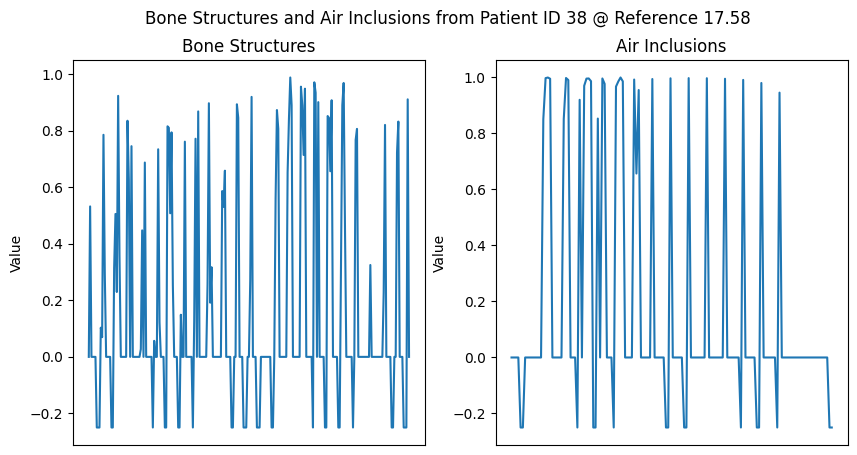

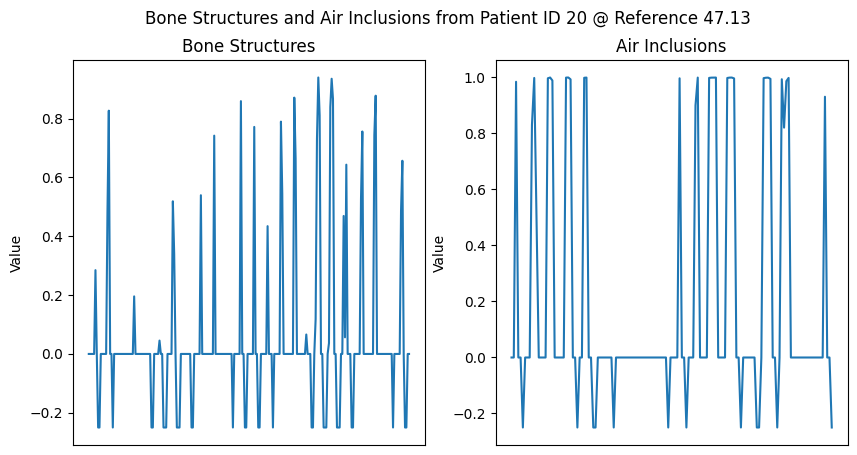

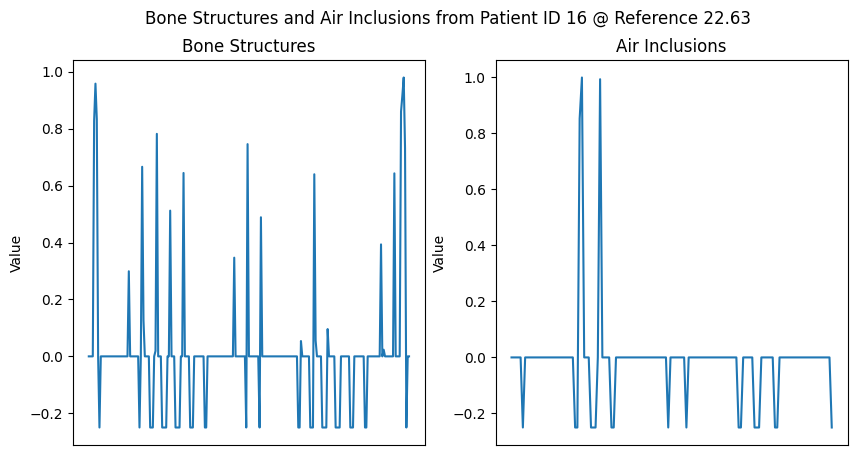

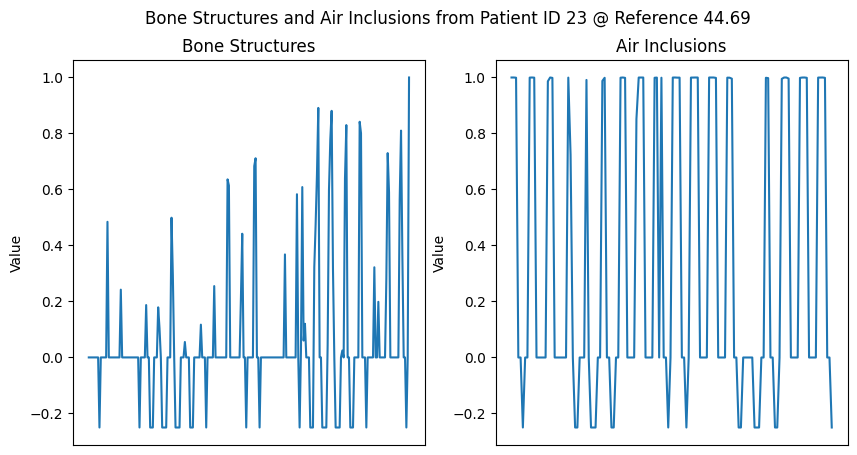

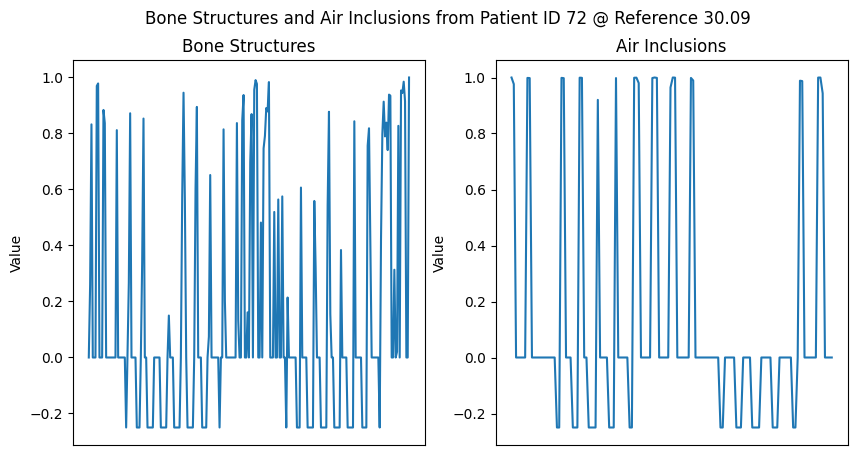

In [24]:
plot_sample_idx = random.Random(RANDOM_SEED).choices(train_data.index, k=5)
for idx in plot_sample_idx:
    plot_sample_histograms(train_data.loc[[idx]])

We can be fairly sure now that the histograms do differ. One observation on the histograms is that there are 3 main types of values, -0.25 (described as "outside of the image"), 0, and positive values.

An assumption might be made that the amount of different types of values correlate with our target. Let's try that.

## Target Pattern

The data is going to be encoded to positive, zero, and negative. Each category will then be counted and analyze for patterns with the target.

In [25]:
def count_encoded_value(df: pd.DataFrame) -> pd.DataFrame:
    encoded_df = df.copy()
    encoded_df[df < 0.] = "neg"
    encoded_df[df == 0.] = "zero"
    encoded_df[df > 0.] = "pos"
    count_df = encoded_df.apply(lambda x: x.value_counts(), axis=1)
    return count_df

count_df = pd.concat([count_encoded_value(train_data[hist_cols]), train_data["reference"]], axis=1)

In [26]:
# Examples of the encoded data
count_df.head()

,neg,pos,zero,reference
0,58,69,257,21.803851
1,58,68,258,21.745726
2,58,67,259,21.687600
3,58,68,258,21.629474
4,58,68,258,21.571348


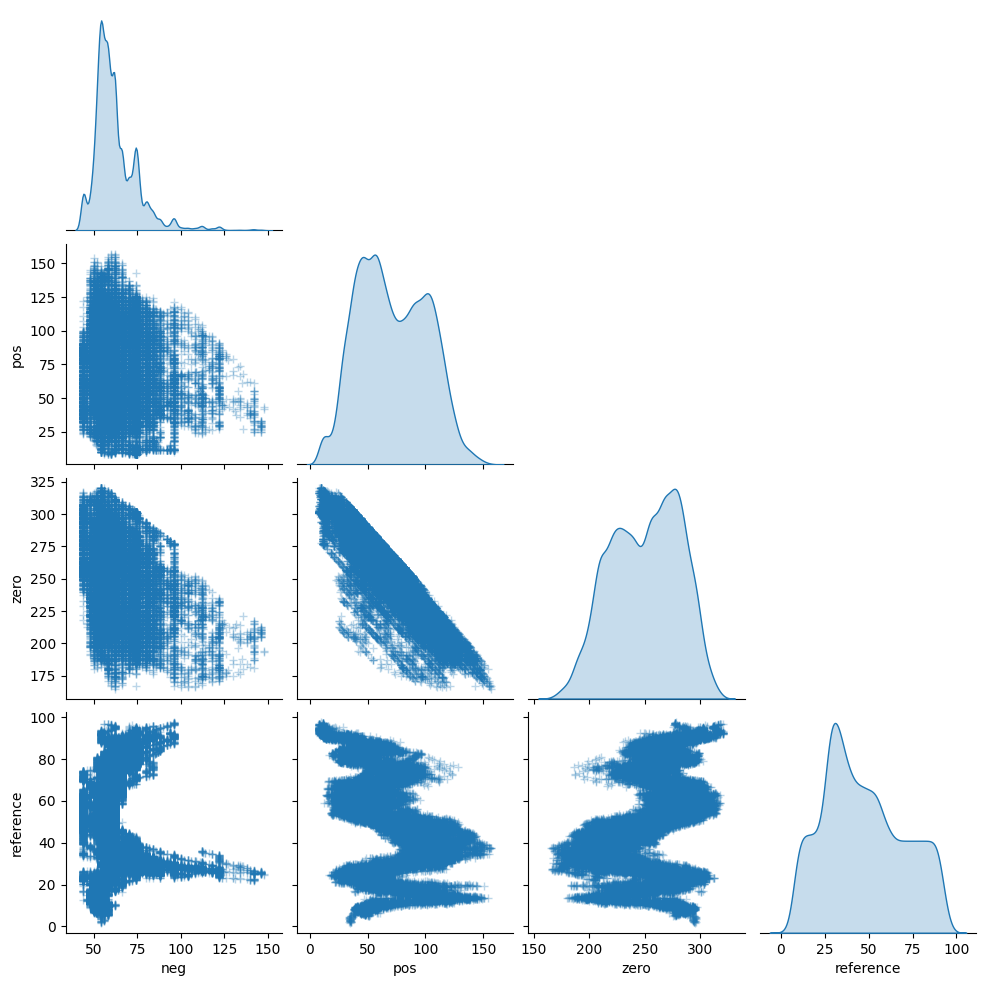

In [27]:
sns.pairplot(count_df, corner=True, plot_kws=dict(marker="+", linewidth=1, alpha=0.3), diag_kind="kde");

Curious shape from the pairplot. Of course the number of each category should correlate with each other (i.e. more positive values means less zeros and negative values).

The interesting part is the correlation between reference and the categories.

The relationship seems to be both non-linear and non-monotonic. Which bears no surprises since a human body is not cone-shaped (afaik).

This could be a starting point for us to use as a baseline. Tree-based model with the encoded features might work quite well if they contains some information on our target.

# Feature Engineering

Let's feature engineer our dataset with what we've already tried.

The number of positive, zero, and negative values are going to be concatenated to the dataset as a "guiding" features for our model.

This is based on the assumption that the number of such categories bears information about the target.

The features are going to be renamed to help with error analysis and feature importance as well.

In [28]:
# Show the first and last column indices for bone structures and air inclusions fields
print(f"First and last column of bone structures fields: {bone_cols[0], bone_cols[-1]}")
print(f"First and last column of air inclusion fields: {air_cols[0], air_cols[-1]}")

First and last column of bone structures fields: ('value1', 'value241')
First and last column of air inclusion fields: ('value242', 'value383')


In [29]:
column_rename_mapping = dict(
    zip(
        [f"value{i}" for i in range(384)],
        [f"bone{i}" for i in range(242)] + [f"air{i}" for i in range(242, 384)]
    )
)

In [30]:
def preprocess(train_data: pd.DataFrame, test_data: pd.DataFrame) -> tuple:
    preprocessed_train = train_data.copy()
    preprocessed_test = test_data.copy()
    # Encode and count before renaming and scaling
    encoded_train_df = count_encoded_value(preprocessed_train[hist_cols])
    encoded_test_df = count_encoded_value(preprocessed_test[hist_cols])
    # Concatenating the encoded data
    preprocessed_train = pd.concat(
        [preprocessed_train.iloc[:, :-1], encoded_train_df, preprocessed_train.iloc[:, -1]],
        axis=1
    )
    preprocessed_test = pd.concat(
        [preprocessed_test.iloc[:, :-1], encoded_test_df, preprocessed_test.iloc[:, -1]],
        axis=1
    )
    # Rename 
    preprocessed_train = preprocessed_train.rename(columns=column_rename_mapping)
    preprocessed_test = preprocessed_test.rename(columns=column_rename_mapping)
    # Scale the features
    scaler = StandardScaler()
    preprocessed_train.iloc[:, 1:-1] = scaler.fit_transform(preprocessed_train.iloc[:, 1:-1])
    preprocessed_test.iloc[:, 1:-1] = scaler.transform(preprocessed_test.iloc[:, 1:-1])
    return preprocessed_train, preprocessed_test, scaler

In [31]:
preprocessed_train, preprocessed_test, scaler = preprocess(train_data, test_data)

In [32]:
preprocessed_train.head()

,patientId,bone0,bone1,bone2,bone3,bone4,bone5,bone6,bone7,bone8,...,air378,air379,air380,air381,air382,air383,neg,pos,zero,reference
0,0,-0.341371,-0.362753,-0.493233,-0.614457,-0.727363,-0.739086,-1.27844,-1.050283,-0.782125,...,-0.729653,-0.707995,-0.583574,-0.281503,-2.114703,-0.798846,-0.346295,-0.080206,0.218384,21.803851
1,0,-0.341371,-0.362753,-0.493233,-0.614457,-0.727363,-0.739086,-1.27844,-1.050283,-0.782125,...,-0.729653,-0.707995,-0.583574,-0.281503,-2.114703,-0.798846,-0.346295,-0.114055,0.250551,21.745726
2,0,-0.341371,-0.362753,-0.493233,-0.614457,-0.727363,-0.739086,-1.27844,-1.050283,-0.782125,...,-0.729653,-0.707995,-0.583574,-0.281503,-2.114703,-0.798846,-0.346295,-0.147904,0.282719,21.687600
3,0,-0.341371,-0.362753,-0.493233,-0.614457,-0.727363,-0.739086,-1.27844,-1.050283,-0.782125,...,-0.729653,-0.707995,-0.583574,-0.281503,-2.114703,-0.798846,-0.346295,-0.114055,0.250551,21.629474
4,0,-0.341371,-0.362753,-0.493233,-0.614457,-0.727363,-0.739086,-1.27844,-1.050283,-0.782125,...,-0.729653,-0.707995,-0.583574,-0.281503,-2.114703,-0.798846,-0.346295,-0.114055,0.250551,21.571348


In [33]:
# Split the validation data from the training set
preprocessed_val = preprocessed_train[preprocessed_train["patientId"].isin(val_ids)]
preprocessed_train = preprocessed_train[preprocessed_train["patientId"].isin(train_ids)]

In [34]:
# Create the arrays of train, validation, and test data
# Remove `patientID` and separate out the target
X_train = preprocessed_train.iloc[:, 1:-1].values
y_train = preprocessed_train.iloc[:, -1].values
X_val = preprocessed_val.iloc[:, 1:-1].values
y_val = preprocessed_val.iloc[:, -1].values
X_test = preprocessed_test.iloc[:, 1:-1].values
y_test = preprocessed_test.iloc[:, -1].values

In [35]:
print(f"Shape of train features and target: {X_train.shape, y_train.shape}")
print(f"Shape of validation features and target: {X_val.shape, y_val.shape}")
print(f"Shape of test features and target: {X_test.shape, y_test.shape}")

Shape of train features and target: ((30956, 387), (30956,))
Shape of validation features and target: ((11020, 387), (11020,))
Shape of test features and target: ((11524, 387), (11524,))


All seems to be in order. Before we start modeling, let's create a function to evaluate the result first.

# Evaluation Utility

In [36]:
def evaluate(model, X, y, show_plots=True):
    y_pred = model.predict(X).flatten()
    clear_output(wait=True)
    mae = mean_absolute_error(y, y_pred)
    rmse = mean_squared_error(y, y_pred, squared=False)
    print(f"Mean absolute error: {mae:.2f}")
    print(f"Root mean squared error: {rmse:.2f}")
    
    if show_plots:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        # Plot Target vs. Prediction
        axes[0].scatter(y_pred, y, alpha=0.1, label="Prediction")
        axes[0].plot([y.min(), y.max()], [y.min(), y.max()], "r--", label="Target")
        axes[0].legend()
        axes[0].set_xlabel("Prediction")
        axes[0].set_ylabel("Target")
        axes[0].set_title("Targets vs. Predictions")
        # Residual plot
        resid = y - y_pred
        axes[1].scatter(y_pred, resid, alpha=0.1)
        axes[1].plot([y_pred.min(), y_pred.max()], [0, 0], "r--")
        axes[1].set_xlabel("Prediction")
        axes[1].set_ylabel("Residual")
        axes[1].set_title("Residuals")

    else:
        return mae, rmse

# Baseline Model

For the baseline model, a simple regression tree is going to be used.

In [37]:
dt_reg = DecisionTreeRegressor(max_depth=10, random_state=RANDOM_SEED)

In [38]:
if LOAD_MODELS:
    dt_reg = np.load("dt.npy", allow_pickle=True).item()
    
else:
    dt_reg.fit(X_train, y_train)
    np.save("dt.npy", dt_reg)

Mean absolute error: 1.72
Root mean squared error: 3.98


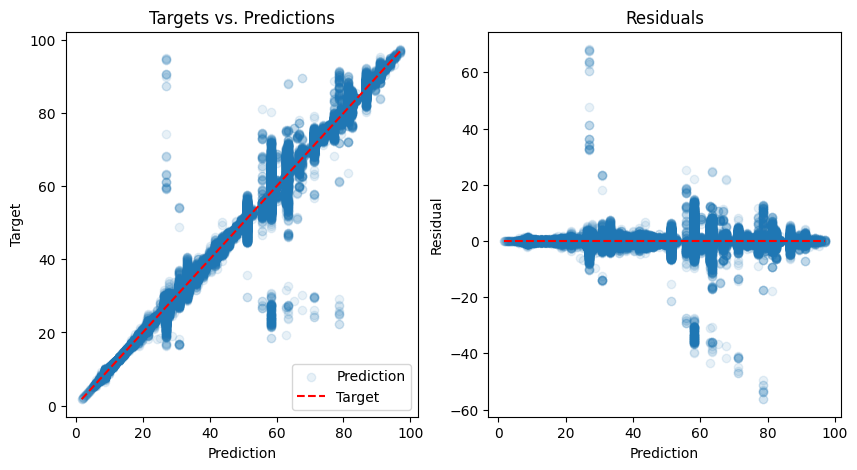

In [39]:
evaluate(dt_reg, X_train, y_train)

Mean absolute error: 4.49
Root mean squared error: 10.35


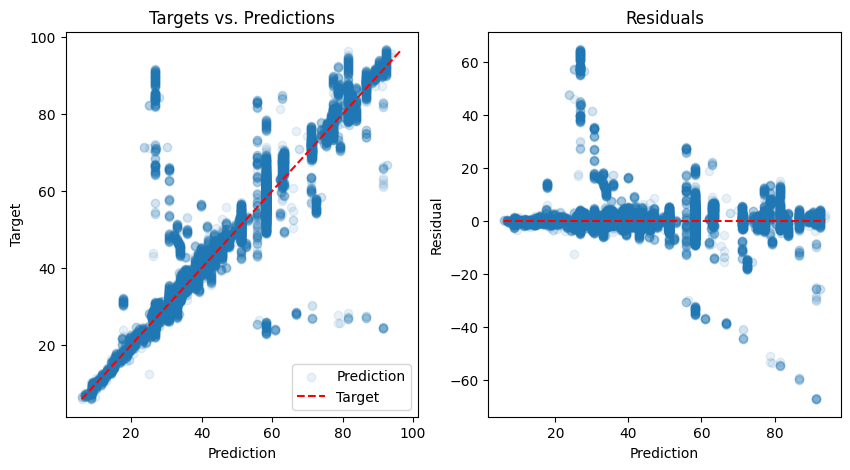

In [40]:
evaluate(dt_reg, X_val, y_val)

From what we can observe from the plots, there are two regions that show high errors.
- The model mispredicted many samples that has actual values more than 40 to be around 30.
- The model also mispredicted many samples that has actual values around 25 to be much higher.
- This error pattern showed on evaluations on both training set and validation set.

The performance of the baseline model on validation set is
- Mean absolute error: 4.49
- Root mean squared error: 10.35

Let's see if neural networks can beat this.

# Dense Network

Given the dimensionality of the features and target, a shallow network of dense layers should suffice. Some regularizations should help in case of overfitting.

In [41]:
def plot_history(history, log_scale=False):
    loss = history["loss"]
    val_loss = history["val_loss"]
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, color="#ff7f0e", label="Validation loss")
    if log_scale:
        plt.yscale("log")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

In [42]:
def build_dense_model():
    inputs = layers.Input(shape=(X_train.shape[1],))
    x = layers.Dense(256, activation="tanh")(inputs)
    x = layers.Dense(64, activation="tanh")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(1)(x)
    outputs = layers.ReLU(max_value=180.0)(x) # Use ReLU as output clipping
    model = keras.Model(inputs, outputs)
    return model

In [43]:
dense_reg = build_dense_model()
dense_reg.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 387)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        99,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,841 (452.50 KB)

 Trainable params: 115,841 (452.50 KB)

 Non-trainable params: 0 (0.00 B)

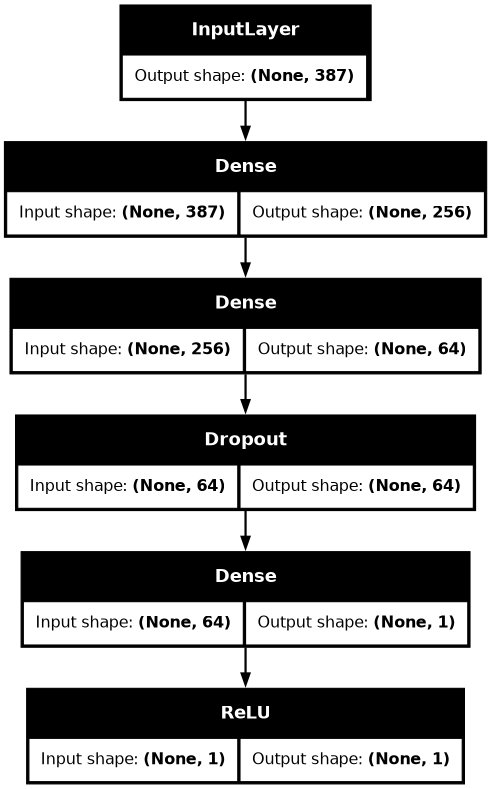

In [44]:
keras.utils.plot_model(dense_reg, to_file="dense_model.png", show_shapes=True, dpi=80)

In [45]:
metrics = [keras.metrics.RootMeanSquaredError(), "mae"]
dense_reg.compile(optimizer="adam", loss="mse", metrics=metrics, jit_compile=False)
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(WORKING_DIR, "dense.keras"), 
        save_best_only=True
    ),
]

In [46]:
if LOAD_MODELS:
    dense_reg = keras.models.load_model(os.path.join(WORKING_DIR, "dense.keras"))
    dense_history = np.load("dense_history.npy", allow_pickle=True).item()

else:
    metrics = [keras.metrics.RootMeanSquaredError(), "mae"]
    dense_reg.compile(optimizer="adam", loss="mse", metrics=metrics, jit_compile=False)
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(WORKING_DIR, "dense.keras"), 
            save_best_only=True
        ),
    ]
    history = dense_reg.fit(
        X_train, 
        y_train, 
        batch_size=64, 
        epochs=20,
        callbacks=callbacks,
        validation_data=(X_val, y_val),
        shuffle=False,
        verbose=0
    )
    # Save the history
    dense_history = history.history
    np.save('dense_history.npy', dense_history, allow_pickle=True)

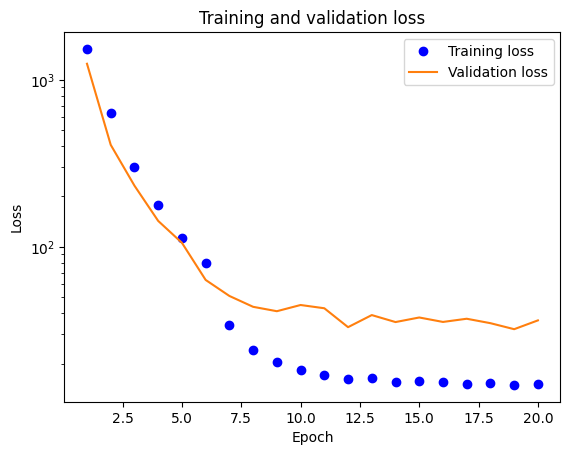

In [47]:
plot_history(dense_history, log_scale=True)

The validation loss started to plateaued at around epoch 12. Let's load the model with best validation loss and evaluate.

In [48]:
train_loss, _, _ = dense_reg.evaluate(X_train, y_train, verbose=0)
print(f"Dense model train loss: {train_loss}")

Dense model train loss: 3.085714340209961


Mean absolute error: 1.28
Root mean squared error: 1.76


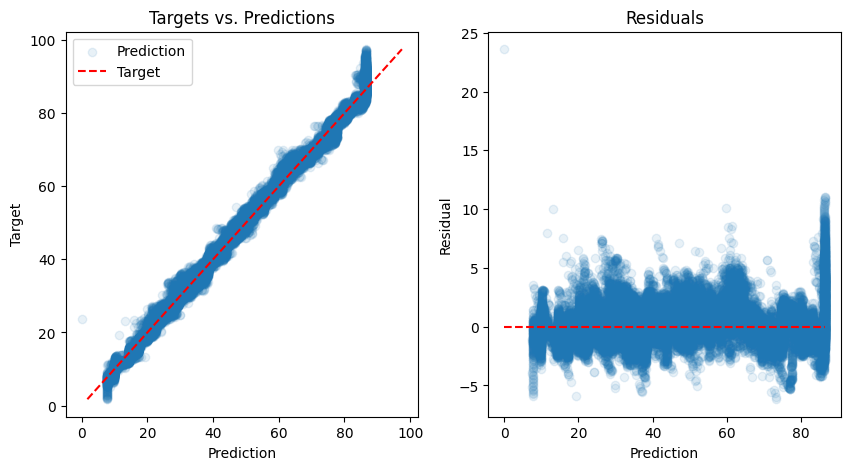

In [49]:
evaluate(dense_reg, X_train, y_train)

In [50]:
val_loss, _, _ = dense_reg.evaluate(X_val, y_val, verbose=0)
print(f"Dense model validation loss: {val_loss}")

Dense model validation loss: 36.29461669921875


Mean absolute error: 3.37
Root mean squared error: 6.02


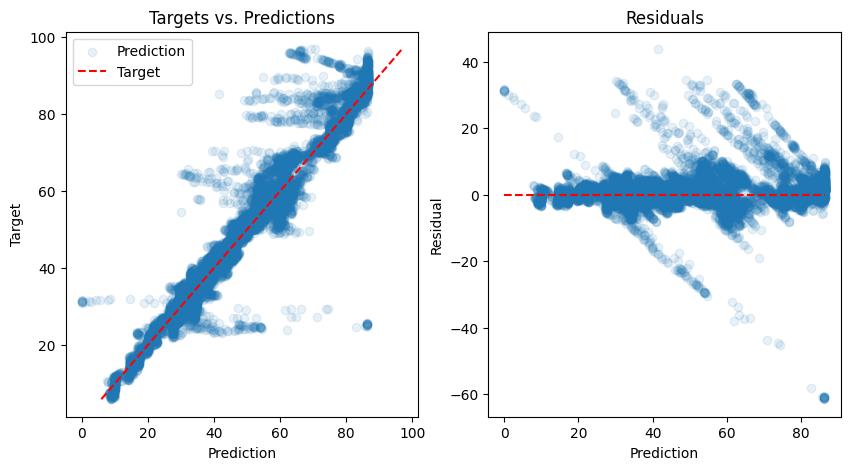

In [51]:
evaluate(dense_reg, X_val, y_val)

With a shallow dense network, we got the MAE on validation set down to 3.07. An improvement from our baseline.

Some notes on the plots
- The model fitted on the training data quite well except on the target values 80 and above. The model predictions don't go above 85 or so. This might indicates different range of targets between training set and validation set.
- Evaluation on the validation set still shows a number of high errors at target values around 25.

Next, convolution network.

# Convolution Network

Assuming the nearby values in the features are important but the distance between them might differs from patient to patient, we can try to "condense" the data so the patterns become more easier to capture.

Let's try extending from the dense network.

In [52]:
def build_conv_model():
    inputs = layers.Input(shape=(X_train.shape[1],))
    # Convolution block
    reshape = layers.Reshape(target_shape=(X_train.shape[1], 1))(inputs)
    conv1 = layers.Conv1D(filters=64, kernel_size=8, padding="same")(reshape)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.ReLU()(conv1)
    conv1 = layers.GlobalMaxPooling1D()(conv1)
    conv1 = layers.Flatten()(conv1)
    # Combine outputs from convolution block and input
    concat = layers.Concatenate()([conv1, inputs])
    # Dense block
    dense1 = layers.Dense(256, activation="tanh")(concat)
    dense1 = layers.Dense(64, activation="tanh")(dense1)
    
    x = layers.Dropout(0.1)(dense1)
    x = layers.Dense(1)(x)
    outputs = layers.ReLU(max_value=180.0)(x) # Use ReLU as output clipping
    model = keras.Model(inputs, outputs)
    return model

In [53]:
conv_reg = build_conv_model()
conv_reg.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 387)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 387, 1)    │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 387, 64)   │        576 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 387, 64)   │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 387, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ re_lu_1[0][0]     │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 64)        │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 451)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    115,712 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │     16,448 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 1)         │          0 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 133,057 (519.75 KB)

 Trainable params: 132,929 (519.25 KB)

 Non-trainable params: 128 (512.00 B)

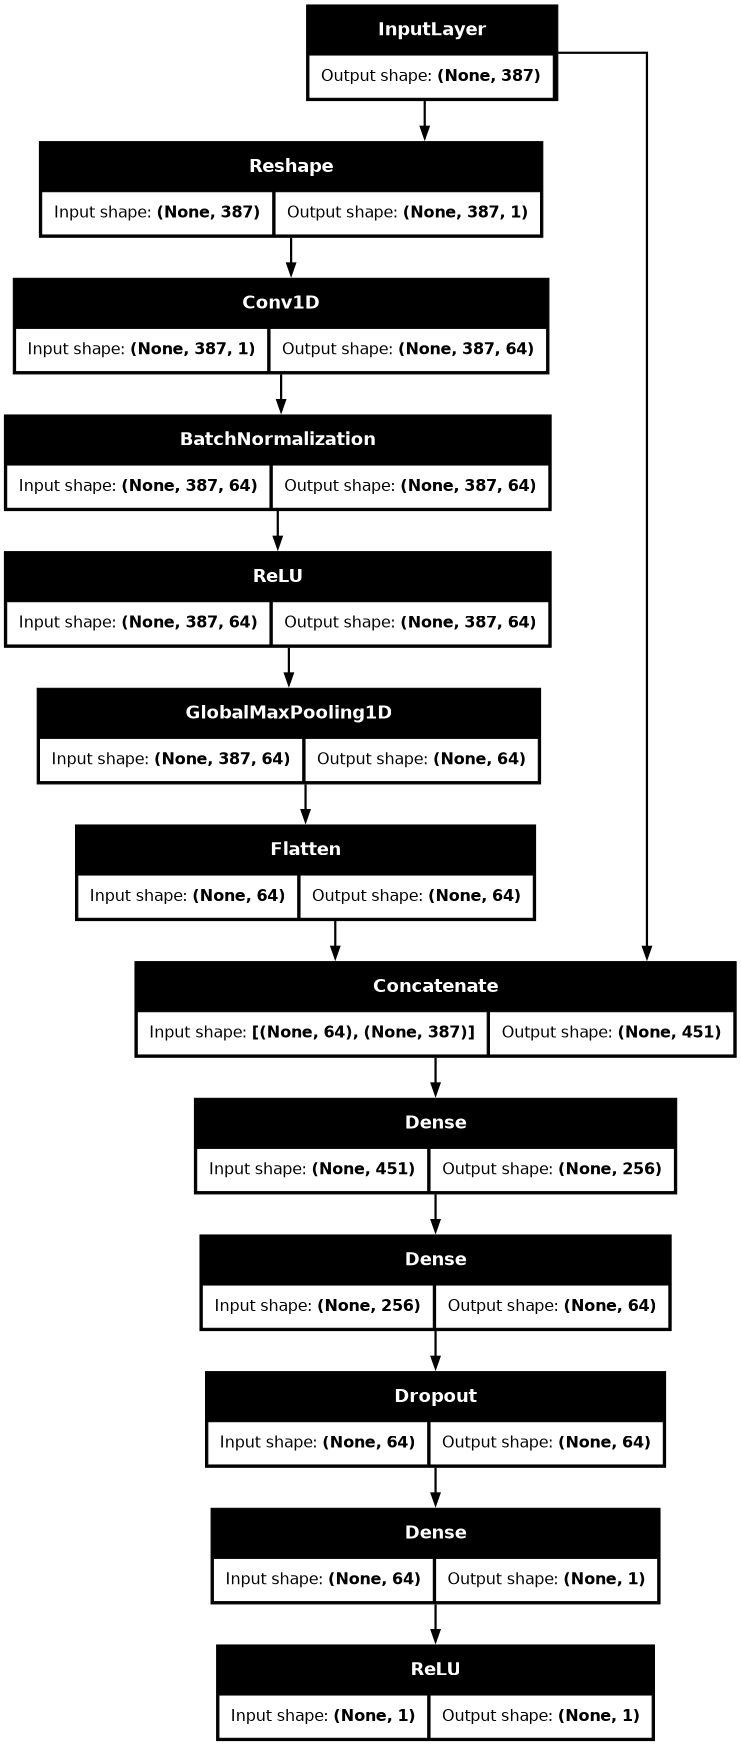

In [54]:
keras.utils.plot_model(conv_reg, to_file="conv_model.png", show_shapes=True, dpi=80)

In [55]:
if LOAD_MODELS:
    conv_reg = keras.models.load_model(os.path.join(WORKING_DIR, "conv.keras"))
    conv_history = np.load("conv_history.npy", allow_pickle=True).item()

else:
    metrics = [keras.metrics.RootMeanSquaredError(), "mae"]
    conv_reg.compile(optimizer="adam", loss="mse", metrics=metrics, jit_compile=False)
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(WORKING_DIR, "conv.keras"), 
            save_best_only=True
        ),
    ]
    history = conv_reg.fit(
        X_train, 
        y_train, 
        batch_size=64,
        epochs=20,
        callbacks=callbacks,
        validation_data=(X_val, y_val),
        shuffle=False,
        verbose=0
    )
    # Save the history
    conv_history = history.history
    np.save('conv_history.npy', dense_history, allow_pickle=True)

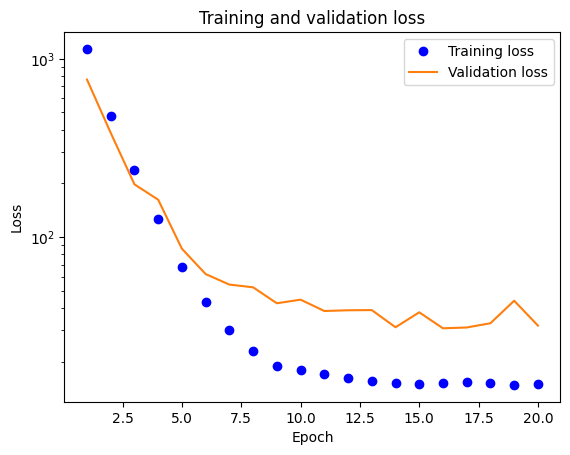

In [56]:
plot_history(conv_history, log_scale=True)

Similar to the dense model, the validation loss started to plateaued at around epoch 12.

In [57]:
train_loss, _, _ = conv_reg.evaluate(X_train, y_train, verbose=0)
print(f"Convolution model train loss: {train_loss}")

Convolution model train loss: 3.029092788696289


Mean absolute error: 1.26
Root mean squared error: 1.74


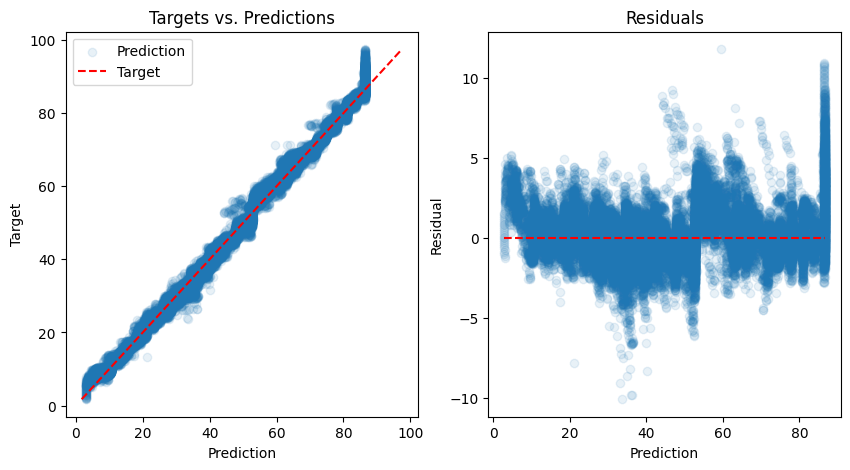

In [58]:
evaluate(conv_reg, X_train, y_train)

In [59]:
val_loss, _, _ = conv_reg.evaluate(X_val, y_val, verbose=0)
print(f"Convolution model validation loss: {val_loss}")

Convolution model validation loss: 31.93300437927246


Mean absolute error: 3.06
Root mean squared error: 5.65


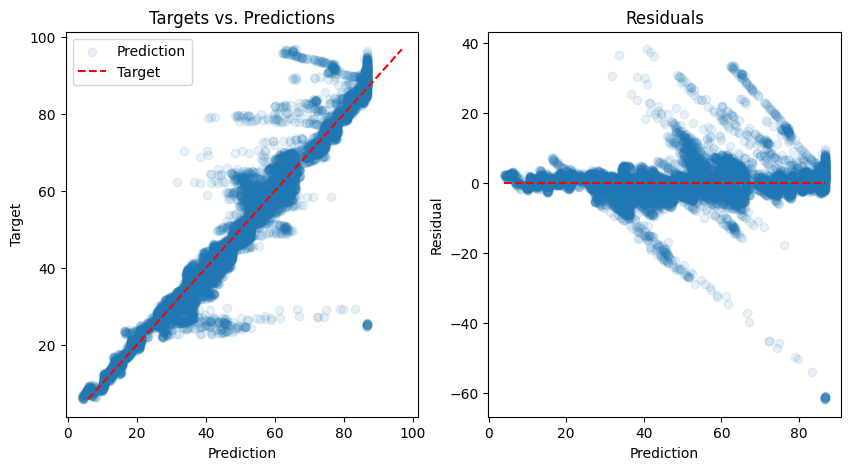

In [60]:
evaluate(conv_reg, X_val, y_val)

With a convolution + dense network, we got the MAE on validation set down to 2.95. Even more improvement.

Some observations
- Like the shallow dense network, the model fitted on the training data quite well except on the target values 80 and above.
- Predictions on validation set still shows higher errors at target values around 25.

# Feature Importance

Now we got some good model candidates, let's see how the different models are affected by the features.

The tool for calculating the feature importances we'll use is `shap`.

Starts with decision tree.

In [61]:
# Prepare some dataframes to be used as inputs to shap Explainer
X_train_df = preprocessed_train.iloc[:, 1:-1]
y_train_df = preprocessed_train.iloc[:, [-1]]

In [62]:
def plot_shap(shap_values, X):
    shap.plots.bar(shap_values, max_display=20)
    shap.summary_plot(shap_values, X, max_display=20, plot_size=0.4)
    plt.show()

## Decision Tree

Since it already contains its own feature importance (Gini importance), we'll also plot that to compare with shap result.

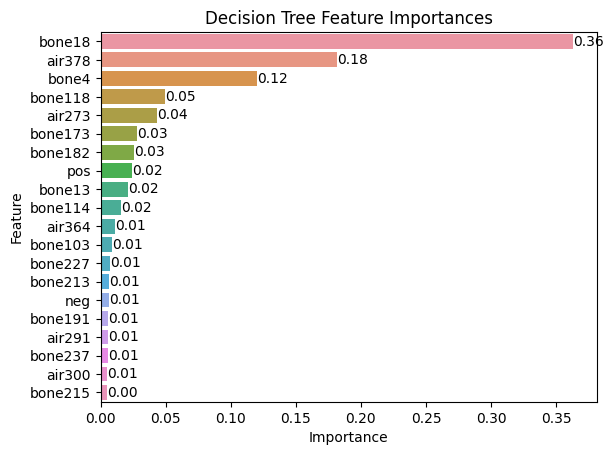

In [63]:
dt_feat_imp = (
    pd.DataFrame(
        dt_reg.feature_importances_, 
        index=X_train_df.columns,
        columns=["feature_importance"])
    .sort_values(by="feature_importance", ascending=False)
    .iloc[:20] # Top 20 features
)
ax = sns.barplot(dt_feat_imp.T, orient="h")
ax.set_xlabel("Importance")
ax.set_ylabel("Feature")
ax.set_title("Decision Tree Feature Importances")
for i in ax.containers:
    ax.bar_label(i, fmt="%.2f") # Show values
plt.show()

In [64]:
dt_explainer = shap.TreeExplainer(dt_reg, X_train_df)
dt_shap_values = dt_explainer(X_train_df)

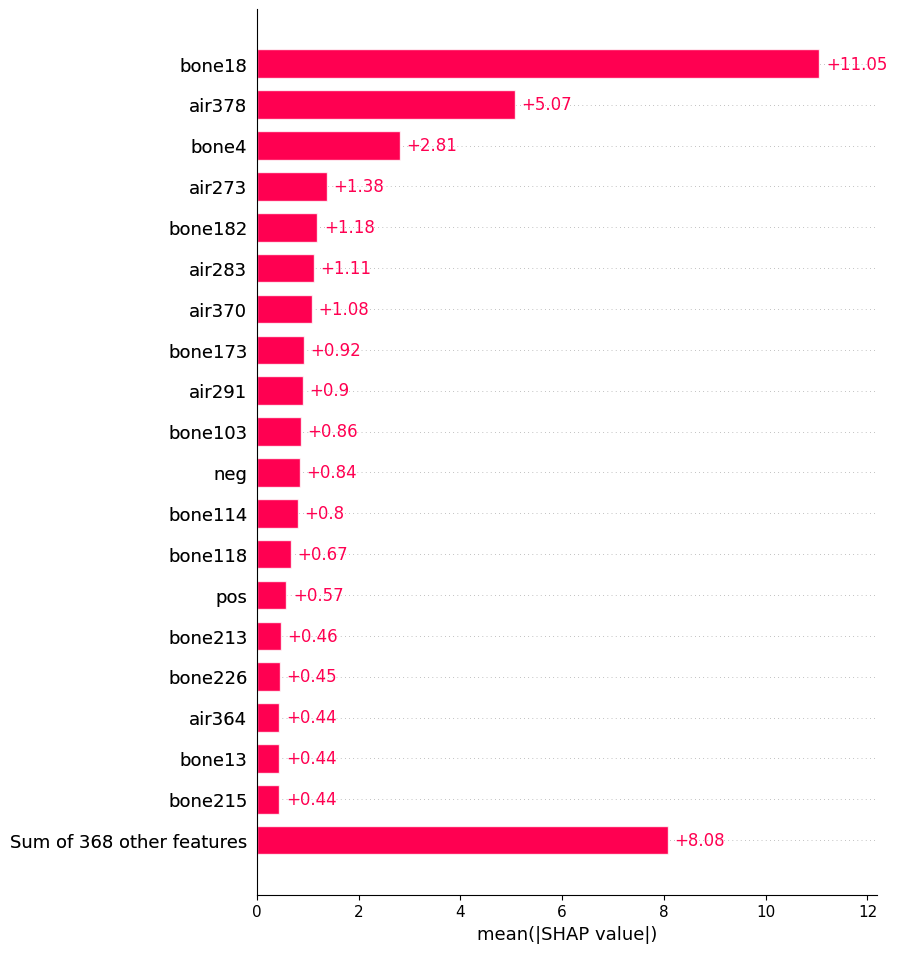

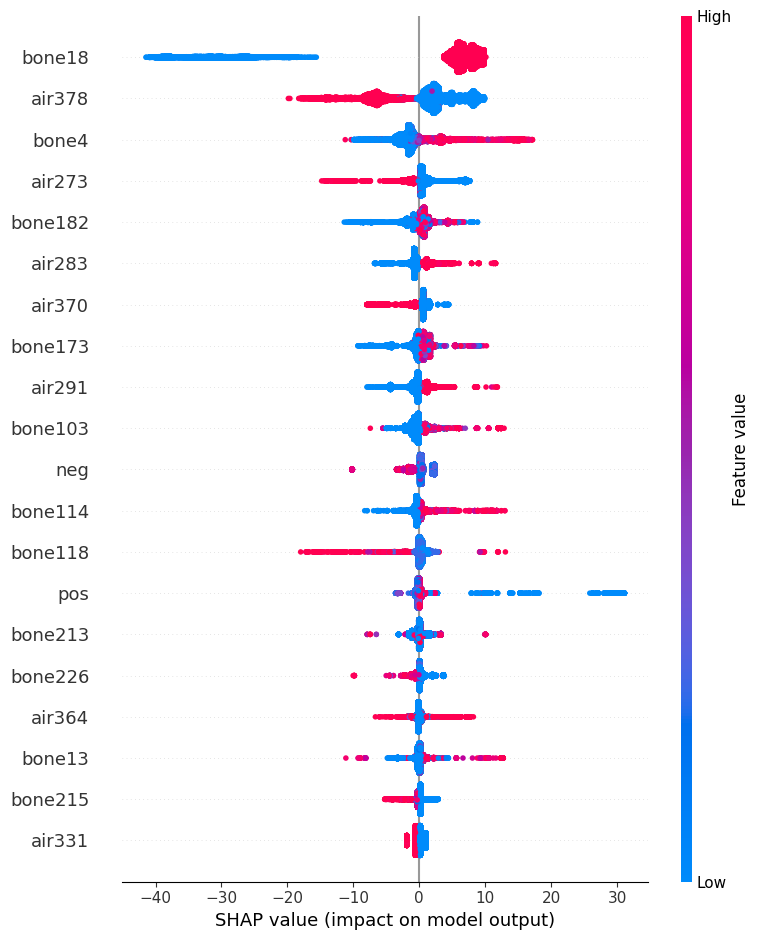

In [65]:
plot_shap(dt_shap_values, X_train_df)

## Dense Network

In [66]:
# Examples to be calculated for shap values
dense_shap_samples = X_train_df.sample(100, random_state=RANDOM_SEED)

In [67]:
if LOAD_SHAP:
    with open("dense_shap_values.pkl", "rb") as f:
        dense_shap_values = pickle.load(f)
else:
    # 500 samples as background
    dense_explainer = shap.DeepExplainer(
        dense_reg,
        X_train_df.sample(500, random_state=RANDOM_SEED).values
    )
    dense_shap_values = dense_explainer(dense_shap_samples.values)
    # Squeeze values in explanation object to match training data shape
    dense_shap_values.values = np.squeeze(dense_shap_values.values, axis=2)
    # Set feature names since we called the explainer with numpy array
    dense_shap_values.feature_names = dense_shap_samples.columns.tolist()
    # Save the calculated shap values
    with open("dense_shap_values.pkl", "wb") as f:
        pickle.dump(dense_shap_values, f)

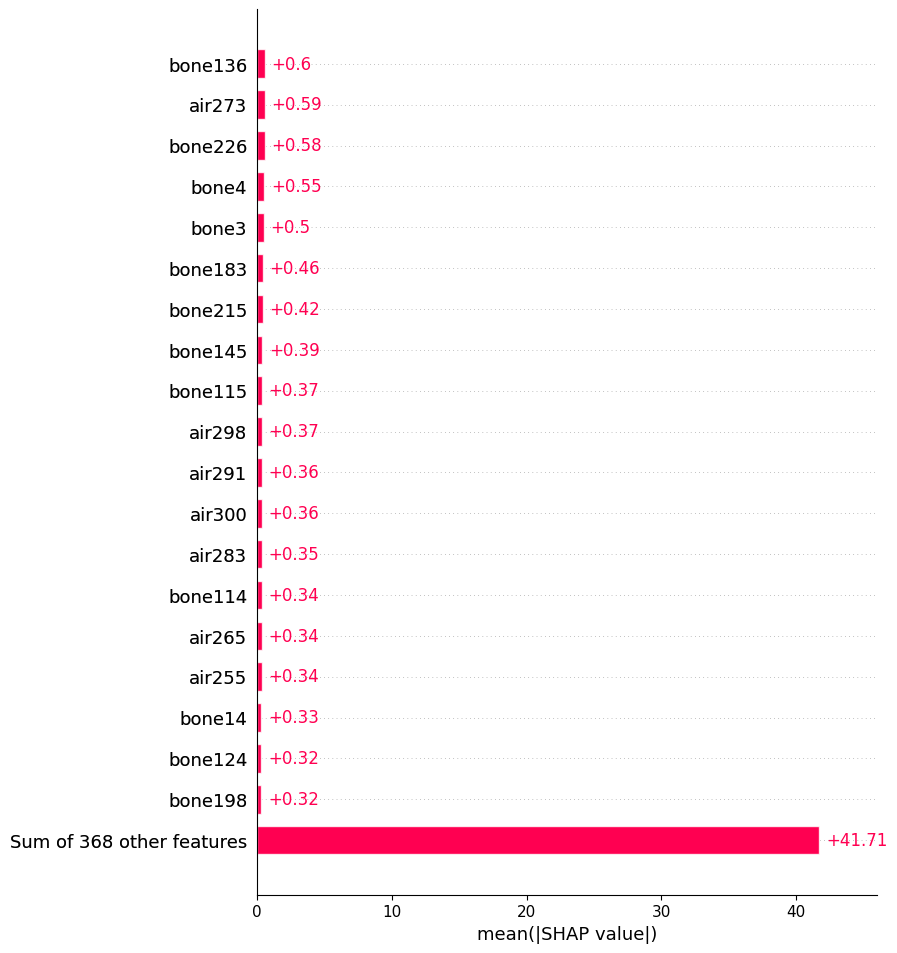

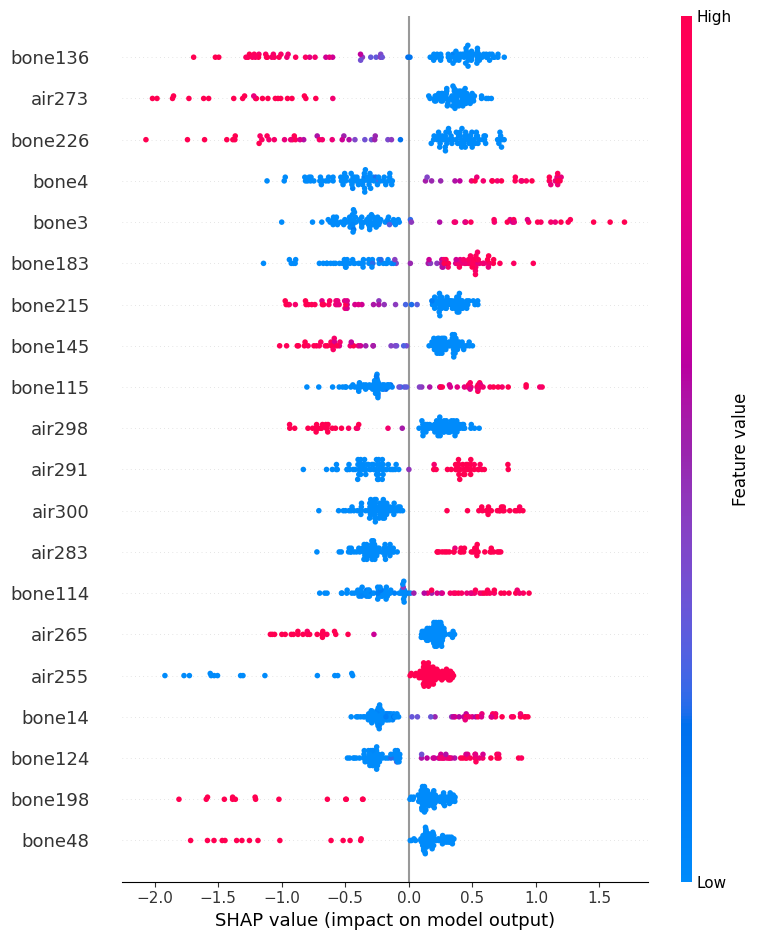

In [68]:
plot_shap(dense_shap_values, dense_shap_samples)

## Convolution Network

Note on running shap on convolution network
- The DeepExplainer class doesn't work with our convolution model. KernelExplainer is used instead.
- The inference time of the convolution network is considerably slower than the dense network. Less background data and explained samples are going to be used.

In [69]:
# Examples to be calculated for shap values
conv_shap_samples = X_train_df.sample(50, random_state=RANDOM_SEED)

In [70]:
if LOAD_SHAP:
    with open("conv_shap_values.pkl", "rb") as f:
        conv_shap_values = pickle.load(f)
else:
    # 100 samples as background
    conv_explainer = shap.KernelExplainer(
        conv_reg.predict,
        X_train_df.sample(100, random_state=RANDOM_SEED).values,
    )
    conv_shap_values = conv_explainer.shap_values(
        conv_shap_samples
    )
    clear_output(wait=True)
    # Squeeze values to match training data shape
    conv_shap_values = np.squeeze(conv_shap_values, axis=2)
    # Create Explanation object with the convolution model's shap values
    conv_shap_values = shap.Explanation(values=conv_shap_values, data=conv_shap_samples.values)
    # Set feature names since we called the explainer with numpy array
    conv_shap_values.feature_names = conv_shap_samples.columns.tolist()
    # Save the calculated shap values
    with open("conv_shap_values.pkl", "wb") as f:
        pickle.dump(conv_shap_values, f)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
8763/8763 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
8763/8763 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
8763/8763 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
8763/8763 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
8763/8763 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
8763/8763 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8763/8763 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8763/8763 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
8763/8763 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
8763/8763 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
8763/8763 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
8763/8763 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step
1/1 ━━━━━━━━━━━━

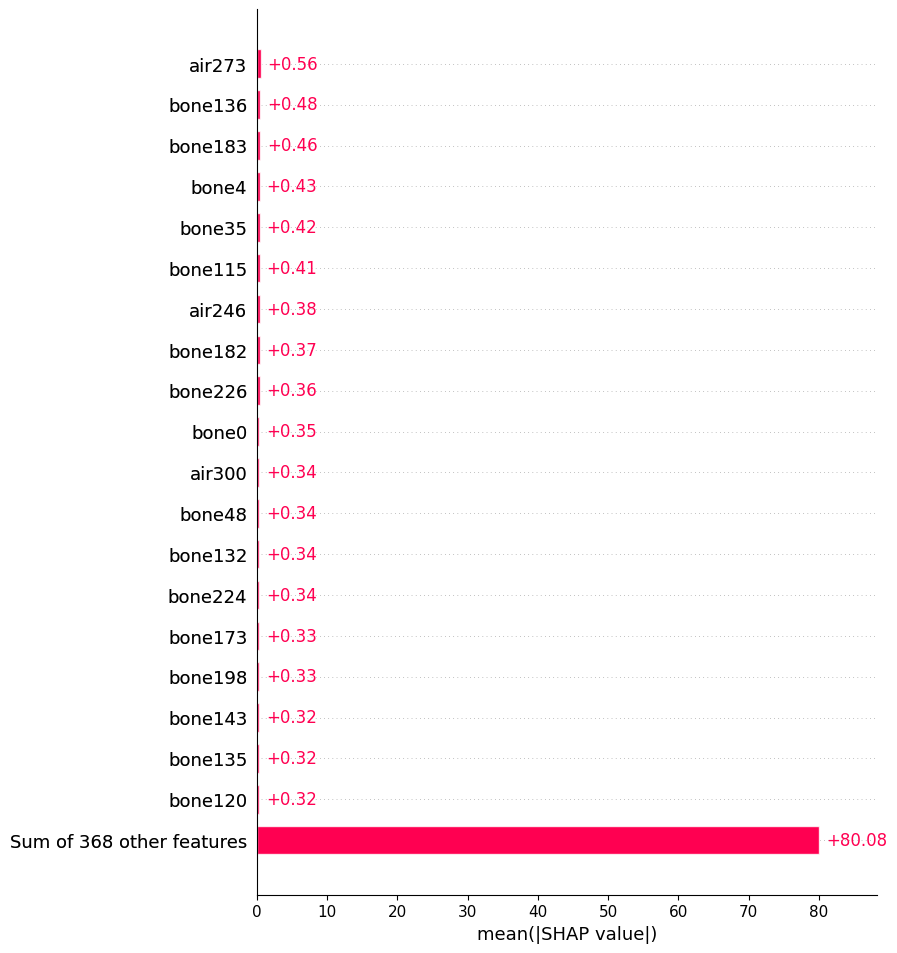

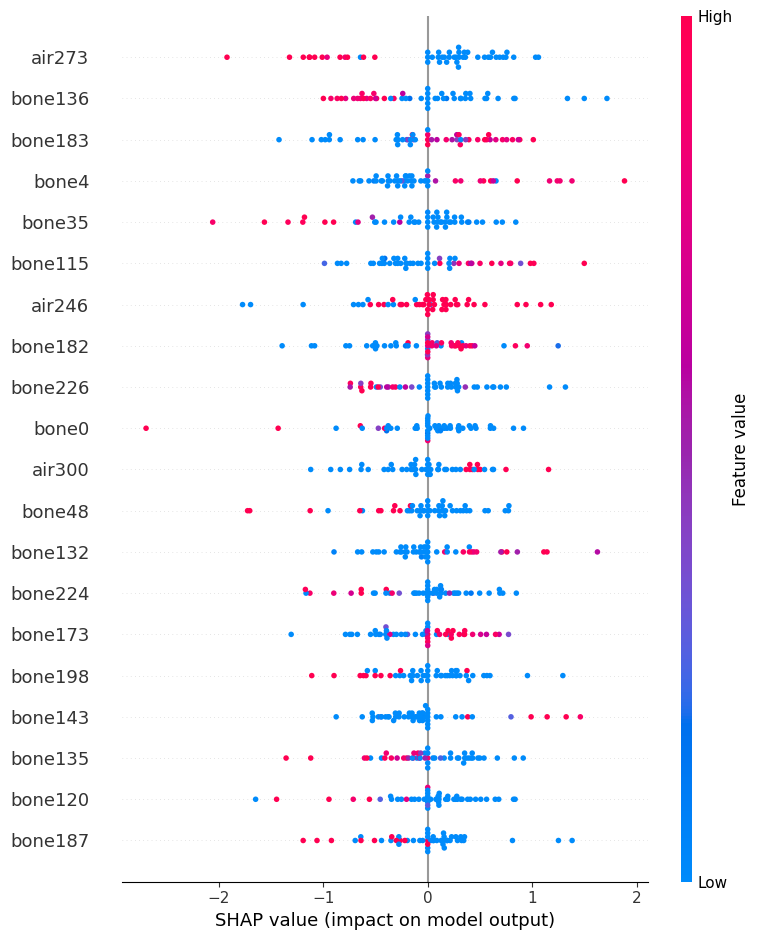

In [71]:
plot_shap(conv_shap_values, conv_shap_samples)

# Error Analysis

In [72]:
high_err_region_val_df = preprocessed_val[preprocessed_val["reference"].between(20, 30)]

In [73]:
high_err_region_train_df = preprocessed_train[preprocessed_train["reference"].between(20, 30)]

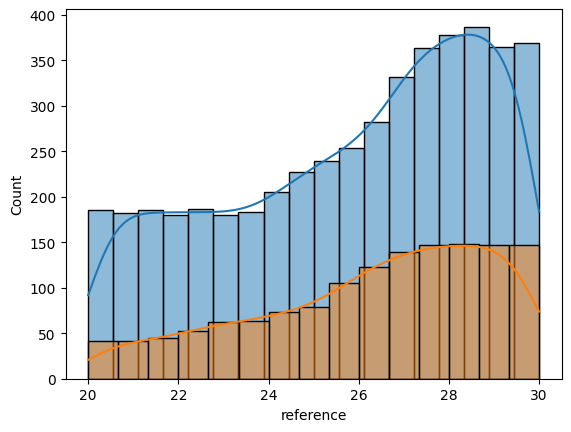

In [74]:
ax = sns.histplot(high_err_region_train_df["reference"], alpha=0.5, kde=True)
sns.histplot(high_err_region_val_df["reference"], alpha=0.5, kde=True, ax=ax);

# Evaluation

Moment of truth. Time to evaluate the different models with hold-out test set.

In [75]:
dt_test_mae, dt_test_rmse = evaluate(dt_reg, X_test, y_test, show_plots=False)
dense_test_mae, dense_test_rmse = evaluate(dense_reg, X_test, y_test, show_plots=False)
conv_test_mae, conv_test_rmse = evaluate(conv_reg, X_test, y_test, show_plots=False)
clear_output(wait=True)
print("Decision Tree Regressor Performance")
print(f"Mean absolute error: {dt_test_mae:.2f}")
print(f"Root mean squared error: {dt_test_rmse:.2f}", end="\n\n")
print("Dense Network Performance")
print(f"Mean absolute error: {dense_test_mae:.2f}")
print(f"Root mean squared error: {dense_test_rmse:.2f}", end="\n\n")
print("Convolution Network Performance")
print(f"Mean absolute error: {conv_test_mae:.2f}")
print(f"Root mean squared error: {conv_test_rmse:.2f}", end="\n\n")

Decision Tree Regressor Performance
Mean absolute error: 3.07
Root mean squared error: 6.73

Dense Network Performance
Mean absolute error: 2.66
Root mean squared error: 6.99

Convolution Network Performance
Mean absolute error: 1.88
Root mean squared error: 3.17



The best performing model is the combination of convolution network and dense network; achieving mean absolute error of 1.79 and root mean squared error of 3.22.

# Further Studies

- Resizing the bins of bone structures and air inclusions fields might be another way to "aggregate" the values. This might lead to better model if the high-granularity bins are different from person to person; this can be considered a more "manual" form of feature engineering than our convolution + dense network.
- The model are trained on different target values (`reference`) separately. Model that captures information on neighboring observations might perform better (i.e. think about bidirectional RNN). However, this depends on how the inferences are going to be done. If the inference is done in batches of slices from one person this method might be applicable.